In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import project_path
from ciu import determine_ciu
from ciu_tests.loan_data_generator import generate_data

In [2]:
train = pd.read_csv(os.path.join('data','train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [3]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

In [4]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
    train['mean'] = train.groupby(['Name_Title', 'Pclass'])['Age'].transform('mean')
    train['Age'] = train['Age'].fillna(train['mean'])
    z = test.merge(train, on=['Name_Title', 'Pclass'], how='left').drop_duplicates(['PassengerId_x'])
    test['Age'] = np.where(test['Age'].isnull(), z['mean'], test['Age'])
    test['Age'] = test['Age'].fillna(test['Age'].mean())
    del train['mean']
    return train, test

In [5]:
def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test

In [6]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

In [7]:
def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [8]:
def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

In [9]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

In [10]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [11]:
def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [12]:
def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

In [13]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 
                                              'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = drop(train, test)

In [14]:
len(train.columns)

36

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = { "criterion"   : ["gini", "entropy"],
             "min_samples_leaf" : [1, 5, 10],
             "min_samples_split" : [2, 4, 10, 12, 16],
             "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

In [16]:

feature_names = [
    'Age', 'Fare', 'Name_Len', 'Age_Null_Flag', 'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]', 
    'Cabin_num_(65.667, 148.0]', 'Ticket_Len', 'Pclass_3', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Sex_female', 
    'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 
    'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.', 'Name_Title_Mrs.',
    'Name_Title_Miss.', 'Name_Title_Master.', 'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.', 'Name_Title_Col.',
    'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big'
]

case = test.values[3]
example_prediction = gs.predict([test.values[3]])
example_prediction_prob = gs.predict_proba([test.values[3]])
prediction_index = 0 if example_prediction_prob[0][0] > 0.5 else 1

print(feature_names)
print(f'Case: {case}; Prediction {example_prediction}; Probability: {example_prediction_prob}')

['Age', 'Fare', 'Name_Len', 'Age_Null_Flag', 'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]', 'Ticket_Len', 'Pclass_3', 'Pclass_1', 'Pclass_2', 'Sex_male', 'Sex_female', 'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Cabin_Letter_n', 'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.', 'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.', 'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.', 'Name_Title_Col.', 'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big']
Case: [27.      8.6625 16.      0.      0.      0.      1.      6.      1.
  0.      0.      1.      0.      1.      0.      0.      1.      0.
  0.      0.      0.      0.      0.      0.      1.      0.      0.
  0.      0.      0.      0.      0.      0.      1.      0.    ]; Prediction [0]; Probability: [[0.84654599 0.15345401]]


In [17]:

ciu = determine_ciu(
    test.iloc[0, :].to_dict(),
    gs.predict_proba,
    {
        'Age': [0, 80, True],
        'Fare': [0, 512, True],
        'Name_Len': [0, 20000, True],
        'Age_Null_Flag': [0, 1, True],
        'Cabin_num_(1.999, 28.667]': [0, 1, True],
        'Cabin_num_(28.667, 65.667]': [0, 1, True],
        'Cabin_num_(65.667, 148.0]': [0, 1, True],
        'Ticket_Len': [0, 50, True], 'Pclass_3': [0, 1, True], 'Pclass_1': [0, 1, True],
        'Pclass_2': [0, 1, True], 'Pclass_3': [0, 1, True], 'Ticket_Len': [0, 1, True],
        'Pclass_3': [0, 1, True], 'Sex_male': [0, 1, True], 'Sex_female': [0, 1, True],
        'Embarked_S': [0, 1, True], 'Embarked_C': [0, 1, True], 'Embarked_Q': [0, 1, True],
        'Cabin_Letter_n': [0, 1, True], 'Cabin_Letter_C': [0, 1, True], 'Cabin_Letter_E': [0, 1, True],
        'Cabin_Letter_G': [0, 1, True], 'Cabin_Letter_D': [0, 1, True], 'Cabin_Letter_A': [0, 1, True],
        'Cabin_Letter_B': [0, 1, True], 'Cabin_Letter_F': [0, 1, True], 'Name_Title_Mr.': [0, 1, True],
        'Name_Title_Mrs.': [0, 1, True], 'Name_Title_Miss.': [0, 1, True], 'Name_Title_Master.': [0, 1, True],
        'Name_Title_Rev.': [0, 1, True], 'Name_Title_Dr.': [0, 1, True], 'Name_Title_Ms.': [0, 1, True],
        'Name_Title_Col.': [0, 1, True], 'Fam_Size_Nuclear': [0, 1, True], 'Fam_Size_Solo': [0, 1, True],
        'Fam_Size_Big': [0, 1, True]
        
    },
    1000,
    prediction_index,
    #category_mapping
)

/Users/timotheuskampik/Desktop/github/py-ciu/ciu/ciu_object.py:46: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.imshow(grad, extent=[x, x + width, y, y + height], aspect="auto")


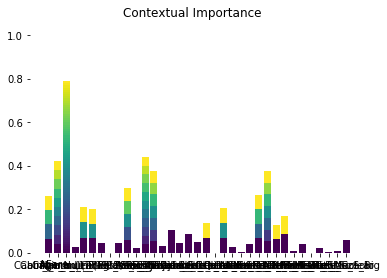

In [18]:
ciu.plot_ci()

In [ ]:
ciu.plot_cu()